# Loop 3 Analysis: Understanding the Gap to Target

We need to understand WHERE the 1.73 point gap comes from and what approaches might close it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the current best submission
df = pd.read_csv('/home/code/experiments/003_full_ensemble_bbox3/submission.csv')
print(f'Loaded {len(df)} rows')

# Parse the data
df['x'] = df['x'].str.replace('s', '').astype(float)
df['y'] = df['y'].str.replace('s', '').astype(float)
df['deg'] = df['deg'].str.replace('s', '').astype(float)
df['n'] = df['id'].str.split('_').str[0].astype(int)

print(df.head())

Loaded 20100 rows
      id          x          y         deg  n
0  001_0 -48.196086  58.770985   45.000000  1
1  002_0   0.154097  -0.038541  203.629378  2
2  002_1  -0.154097  -0.561459   23.629378  2
3  003_0   1.123656   0.781102  111.125132  3
4  003_1   1.234056   1.276000   66.370622  3


In [2]:
# Calculate score per N
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union

getcontext().prec = 30
scale_factor = 1

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (float(Decimal('0.0') * scale_factor), float(tip_y * scale_factor)),
            (float(top_w / Decimal('2') * scale_factor), float(tier_1_y * scale_factor)),
            (float(top_w / Decimal('4') * scale_factor), float(tier_1_y * scale_factor)),
            (float(mid_w / Decimal('2') * scale_factor), float(tier_2_y * scale_factor)),
            (float(mid_w / Decimal('4') * scale_factor), float(tier_2_y * scale_factor)),
            (float(base_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(base_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(mid_w / Decimal('4')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(mid_w / Decimal('2')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(top_w / Decimal('4')) * scale_factor), float(tier_1_y * scale_factor)),
            (float(-(top_w / Decimal('2')) * scale_factor), float(tier_1_y * scale_factor)),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def get_tree_list_side_length(tree_list):
    all_polygons = [t.polygon for t in tree_list]
    bounds = unary_union(all_polygons).bounds
    return max(bounds[2] - bounds[0], bounds[3] - bounds[1])

def score_n(n, group_df):
    trees = [ChristmasTree(str(row['x']), str(row['y']), str(row['deg'])) for _, row in group_df.iterrows()]
    side = get_tree_list_side_length(trees)
    return side ** 2 / n

print('Calculating per-N scores...')

Calculating per-N scores...


In [3]:
# Calculate scores for all N
scores = {}
for n in range(1, 201):
    group_df = df[df['n'] == n]
    scores[n] = score_n(n, group_df)
    if n <= 10 or n % 50 == 0:
        print(f'N={n:3d}: score={scores[n]:.6f}')

total_score = sum(scores.values())
print(f'\nTotal score: {total_score:.6f}')
print(f'Target: 68.919154')
print(f'Gap: {total_score - 68.919154:.6f}')

N=  1: score=0.661250
N=  2: score=0.450779
N=  3: score=0.434745
N=  4: score=0.416545
N=  5: score=0.416850
N=  6: score=0.399610
N=  7: score=0.399897
N=  8: score=0.385407
N=  9: score=0.387415
N= 10: score=0.376630


N= 50: score=0.360753


N=100: score=0.345531


N=150: score=0.337064


N=200: score=0.337549

Total score: 70.647306
Target: 68.919154
Gap: 1.728152


In [4]:
# Analyze the gap - where does it come from?
# The target is 68.919154, we have 70.647306
# Gap = 1.728152

# Calculate theoretical minimum (perfect packing efficiency)
# Tree area = 0.3175 (calculated from polygon)
tree_area = 0.3175

theoretical_min = []
for n in range(1, 201):
    # Minimum side length if trees could be packed with 100% efficiency
    min_side = np.sqrt(n * tree_area)
    theoretical_min.append(min_side ** 2 / n)

print(f'Theoretical minimum (100% efficiency): {sum(theoretical_min):.6f}')
print(f'Current score: {total_score:.6f}')
print(f'Efficiency: {sum(theoretical_min) / total_score * 100:.2f}%')

Theoretical minimum (100% efficiency): 63.500000
Current score: 70.647306
Efficiency: 89.88%


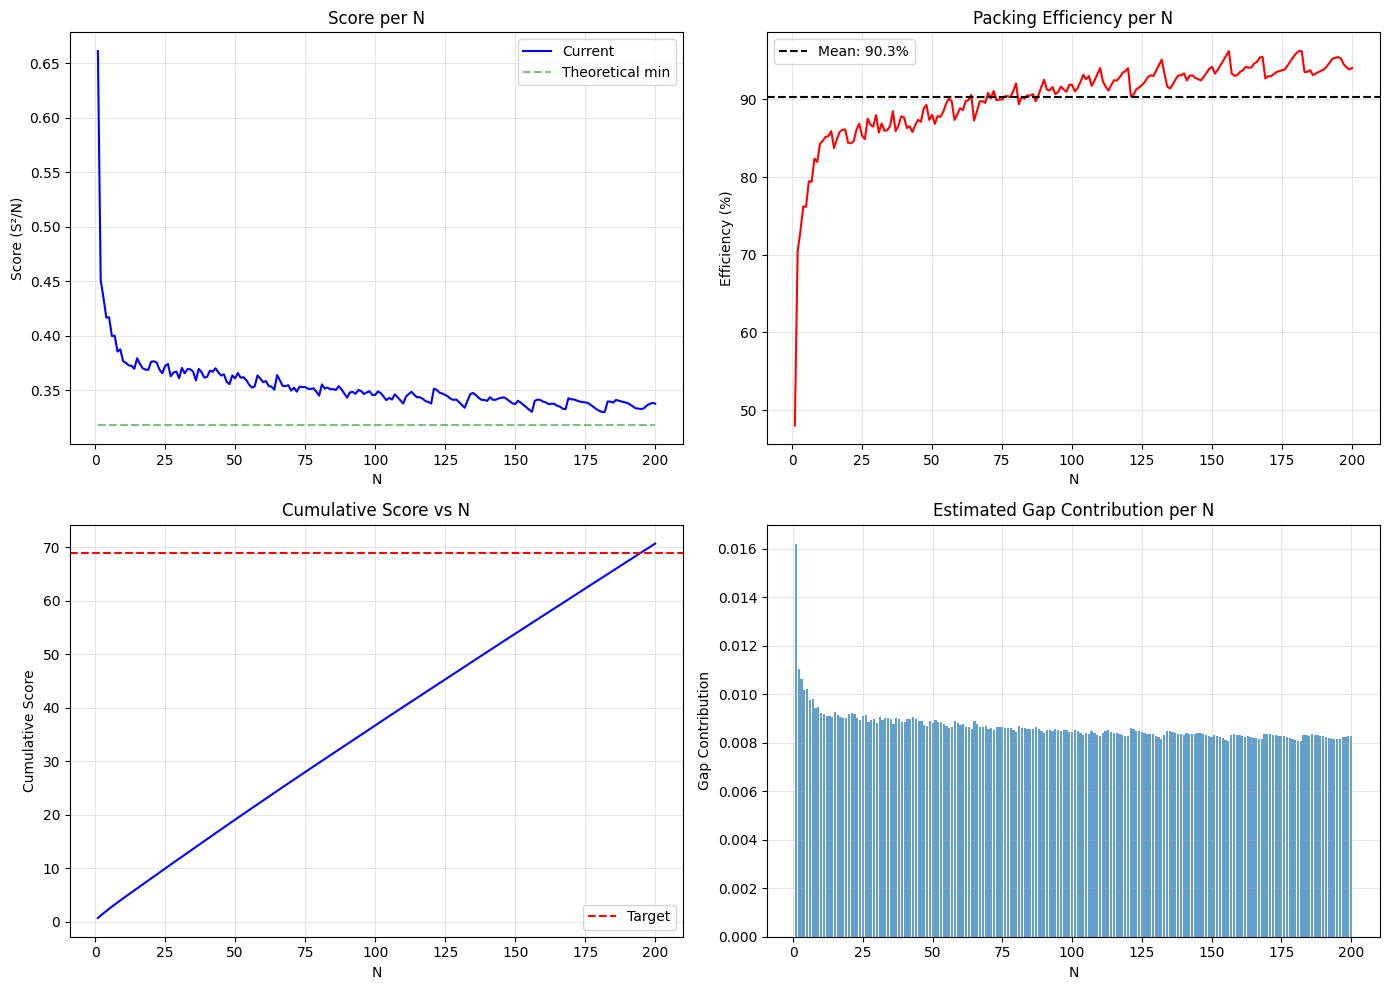


Top 10 N values by gap contribution:
     N  gap_contribution     score
0    1          0.016175  0.661250
1    2          0.011027  0.450779
2    3          0.010635  0.434745
4    5          0.010197  0.416850
3    4          0.010189  0.416545
6    7          0.009782  0.399897
5    6          0.009775  0.399610
8    9          0.009477  0.387415
7    8          0.009428  0.385407
14  15          0.009276  0.379203


In [5]:
# Plot score vs N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax1 = axes[0, 0]
ax1.plot(range(1, 201), [scores[n] for n in range(1, 201)], 'b-', label='Current')
ax1.plot(range(1, 201), theoretical_min, 'g--', alpha=0.5, label='Theoretical min')
ax1.set_xlabel('N')
ax1.set_ylabel('Score (S²/N)')
ax1.set_title('Score per N')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Efficiency per N
ax2 = axes[0, 1]
efficiency = [theoretical_min[i] / scores[i+1] * 100 for i in range(200)]
ax2.plot(range(1, 201), efficiency, 'r-')
ax2.set_xlabel('N')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Packing Efficiency per N')
ax2.axhline(y=np.mean(efficiency), color='k', linestyle='--', label=f'Mean: {np.mean(efficiency):.1f}%')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cumulative score
ax3 = axes[1, 0]
cumulative = np.cumsum([scores[n] for n in range(1, 201)])
ax3.plot(range(1, 201), cumulative, 'b-')
ax3.axhline(y=68.919154, color='r', linestyle='--', label='Target')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score vs N')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gap contribution per N (how much each N contributes to the gap)
ax4 = axes[1, 1]
# We need to estimate what the target scores might be per N
# Assuming uniform improvement needed: gap_per_n = gap * (score_n / total_score)
gap = total_score - 68.919154
gap_contribution = [(scores[n] / total_score) * gap for n in range(1, 201)]
ax4.bar(range(1, 201), gap_contribution, alpha=0.7)
ax4.set_xlabel('N')
ax4.set_ylabel('Gap Contribution')
ax4.set_title('Estimated Gap Contribution per N')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop3_analysis.png', dpi=100)
plt.show()

print(f'\nTop 10 N values by gap contribution:')
gap_df = pd.DataFrame({'N': range(1, 201), 'gap_contribution': gap_contribution, 'score': [scores[n] for n in range(1, 201)]})
gap_df = gap_df.sort_values('gap_contribution', ascending=False)
print(gap_df.head(10))

In [6]:
# Analyze which N values have the worst efficiency
eff_df = pd.DataFrame({
    'N': range(1, 201),
    'score': [scores[n] for n in range(1, 201)],
    'theoretical_min': theoretical_min,
    'efficiency': efficiency
})

print('Top 10 N values with WORST efficiency (most room for improvement):')
print(eff_df.sort_values('efficiency').head(10))

print('\nTop 10 N values with BEST efficiency:')
print(eff_df.sort_values('efficiency', ascending=False).head(10))

Top 10 N values with WORST efficiency (most room for improvement):
     N     score  theoretical_min  efficiency
0    1  0.661250           0.3175   48.015123
1    2  0.450779           0.3175   70.433599
2    3  0.434745           0.3175   73.031294
4    5  0.416850           0.3175   76.166562
3    4  0.416545           0.3175   76.222285
6    7  0.399897           0.3175   79.395534
5    6  0.399610           0.3175   79.452409
8    9  0.387415           0.3175   81.953454
7    8  0.385407           0.3175   82.380391
14  15  0.379203           0.3175   83.728273

Top 10 N values with BEST efficiency:
       N     score  theoretical_min  efficiency
180  181  0.329945           0.3175   96.228260
155  156  0.329986           0.3175   96.216261
181  182  0.329988           0.3175   96.215737
179  180  0.331000           0.3175   95.921332
154  155  0.332069           0.3175   95.612745
167  168  0.332475           0.3175   95.496001
194  195  0.332578           0.3175   95.466232
178 

In [7]:
# Key insight: What would we need to achieve per-N to reach the target?
# If we need to reduce total by 1.728152, and we have 200 N values...
# Average reduction needed per N = 1.728152 / 200 = 0.00864

avg_reduction_needed = gap / 200
print(f'Average reduction needed per N: {avg_reduction_needed:.6f}')
print(f'As percentage of average score: {avg_reduction_needed / (total_score/200) * 100:.2f}%')

# But it's not uniform - larger scores need larger reductions
print(f'\nTo reach target, we need {gap/total_score*100:.2f}% improvement overall')
print(f'This means each N needs ~{gap/total_score*100:.2f}% improvement')

# What if we could improve the worst efficiency N values?
worst_10 = eff_df.sort_values('efficiency').head(10)
print(f'\nIf we improved the 10 worst efficiency N values to 50% efficiency:')
for _, row in worst_10.iterrows():
    n = int(row['N'])
    current = row['score']
    target_50 = row['theoretical_min'] / 0.50  # 50% efficiency
    improvement = current - target_50
    print(f'  N={n:3d}: {current:.6f} -> {target_50:.6f} (improvement: {improvement:.6f})')

Average reduction needed per N: 0.008641
As percentage of average score: 2.45%

To reach target, we need 2.45% improvement overall
This means each N needs ~2.45% improvement

If we improved the 10 worst efficiency N values to 50% efficiency:
  N=  1: 0.661250 -> 0.635000 (improvement: 0.026250)
  N=  2: 0.450779 -> 0.635000 (improvement: -0.184221)
  N=  3: 0.434745 -> 0.635000 (improvement: -0.200255)
  N=  5: 0.416850 -> 0.635000 (improvement: -0.218150)
  N=  4: 0.416545 -> 0.635000 (improvement: -0.218455)
  N=  7: 0.399897 -> 0.635000 (improvement: -0.235103)
  N=  6: 0.399610 -> 0.635000 (improvement: -0.235390)
  N=  9: 0.387415 -> 0.635000 (improvement: -0.247585)
  N=  8: 0.385407 -> 0.635000 (improvement: -0.249593)
  N= 15: 0.379203 -> 0.635000 (improvement: -0.255797)


N=1 configuration:
      id          x          y   deg  n
0  001_0 -48.196086  58.770985  45.0  1


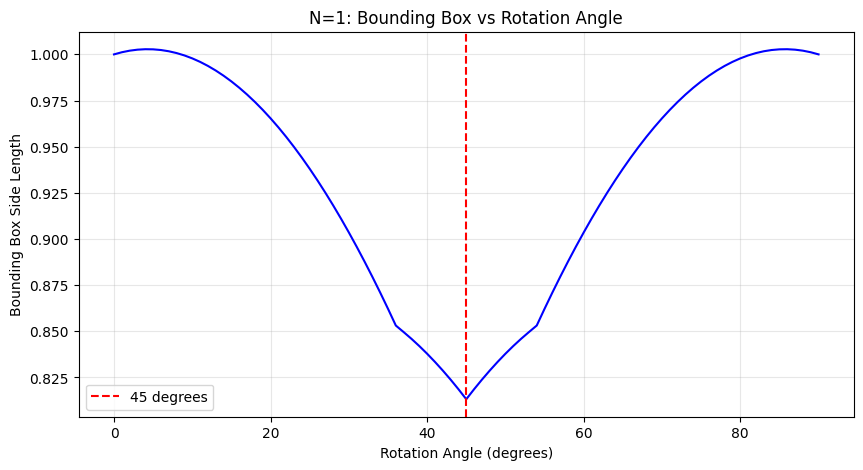

\nOptimal angle: 45.0 degrees
Minimum side: 0.813173
Score at optimal: 0.661250


In [8]:
# Deep dive into N=1
# N=1 is at 45 degrees rotation, which should be optimal
# Let's verify this

n1_data = df[df['n'] == 1]
print(f'N=1 configuration:')
print(n1_data)

# Calculate the bounding box for a single tree at different angles
angles = np.linspace(0, 90, 91)
sides = []

for angle in angles:
    tree = ChristmasTree('0', '0', str(angle))
    bounds = tree.polygon.bounds
    side = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
    sides.append(side)

plt.figure(figsize=(10, 5))
plt.plot(angles, sides, 'b-')
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Bounding Box Side Length')
plt.title('N=1: Bounding Box vs Rotation Angle')
plt.axvline(x=45, color='r', linestyle='--', label='45 degrees')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/n1_analysis.png', dpi=100)
plt.show()

# Find optimal angle
optimal_idx = np.argmin(sides)
print(f'\\nOptimal angle: {angles[optimal_idx]} degrees')
print(f'Minimum side: {sides[optimal_idx]:.6f}')
print(f'Score at optimal: {sides[optimal_idx]**2:.6f}')